In [1]:
import numpy as np
import pandas as pd
import pydicom
%matplotlib inline
import matplotlib.pyplot as plt
import keras 
from keras.models import model_from_json
import skimage.transform

Using TensorFlow backend.
/home/nttputus/anaconda3/envs/gpu-cuda9/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/nttputus/anaconda3/envs/gpu-cuda9/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/nttputus/anaconda3/envs/gpu-cuda9/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home

In [2]:
# This function reads in a .dcm file, checks the important fields for our device, and returns a numpy array
# of just the imaging data
def check_dicom(filename): 
    
    print('Load file {} ...'.format(filename))
    ds = pydicom.dcmread(filename)       
    img = ds.pixel_array
    
    modality = ds.Modality 
    if modality !=  'DX':
        print('Modality is not DX. The image will not be assessed.')
        print()
        return None

    body_part = ds.BodyPartExamined
    if body_part !=  'CHEST':
        print('Body part examined is not Chest. The image will not be assessed.')
        print()
        return None
    
    patient_position= ds.PatientPosition 
    if patient_position not in ['PA', 'AP']:
        print('Patient position is not PA or AP. The image will not be assessed.')
        print()
        return None
    
    findings = ds.StudyDescription
    print('Findings:', findings)
    plt.imshow(img, cmap='gray')
    plt.show()
    
    return img
    
    
# This function takes the numpy array output by check_dicom and 
# runs the appropriate pre-processing needed for our model input
def preprocess_image(img,img_mean,img_std,img_size): 
    
    proc_img = (img-img_mean) / img_std
    proc_img = skimage.transform.resize(proc_img, img_size)
    return proc_img

# This function loads in our trained model w/ weights and compiles it 
def load_model(model_path, weight_path):

    with open(model_path, 'r') as json_file:
        model_json = json_file.read()
        model = model_from_json(model_json)
        model.load_weights(weight_path)    
    
    return model

# This function uses our device's threshold parameters to predict whether or not
# the image shows the presence of pneumonia using our trained model
def predict_image(model, img, thresh): 
    pred_Y = model.predict(img)   
    if pred_Y > thresh:
        return 'Pneumonia'
    else:
        return 'Not pneumonia'
    
    return prediction

Load file test1.dcm ...
Findings: No Finding


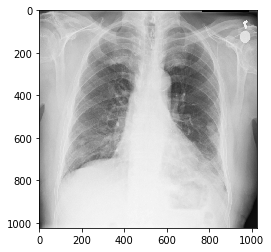

Pneumonia
Load file test2.dcm ...
Findings: Cardiomegaly


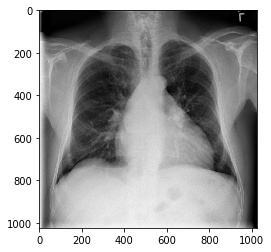

Pneumonia
Load file test3.dcm ...
Findings: Effusion


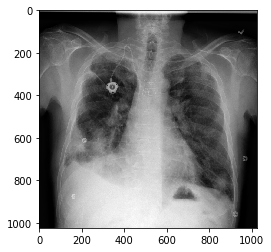

Pneumonia
Load file test4.dcm ...
Body part examined is not Chest. The image will not be assessed.

Load file test5.dcm ...
Modality is not DX. The image will not be assessed.

Load file test6.dcm ...
Patient position is not PA or AP. The image will not be assessed.



In [3]:
test_dicoms = ['test1.dcm','test2.dcm','test3.dcm','test4.dcm','test5.dcm','test6.dcm']

model_path = "model.json"
weight_path = "{}_model.best.hdf5".format('xray_class')

IMG_SIZE=(1,224,224,3) 
img_mean = 0
img_std = 255

my_model = load_model(model_path, weight_path)
thresh = 0.39848339557647705

# use the .dcm files to test your prediction
for i in test_dicoms:
    
    img = np.array([])
    img = check_dicom(i)
    
    if img is None:
        continue
        
    img_proc = preprocess_image(img,img_mean,img_std,IMG_SIZE)
    pred = predict_image(my_model,img_proc,thresh)
    print(pred)